# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
import os
import zipfile
import tarfile
import requests

def download_file(url, path='./'):
    filename = url.split('/')[-1]
    print('Downloading {}'.format(filename))
    path = os.path.join(path, filename)
    r = requests.get(url, stream=True)
    with open(path, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
    print('Download complete')
    return filename

def extract(archive, folder):
    print('Extracting {}'.format(archive))
    
    if (archive.endswith('tgz')):
        tar = tarfile.open(archive, 'r:gz')
        tar.extractall()
        tar.close()
    elif (archive.endswith('zip')):    
        with zipfile.ZipFile(archive, 'r') as zip_ref:
            zip_ref.extractall()
    else:
        print('Archive type {} not recognized'.format(archive))

    if os.path.isdir(folder):
        print('Extracting complete'.format(archive))
    else:
        print('Extracting failed'.format(archive))
        
def download_extract(url, folder, force_download=False):
    filename = url.split('/')[-1]
    downloadPath = os.path.join(os.getcwd(), folder)
    if os.path.isdir(downloadPath) is False:
        if os.path.exists(filename):
            if force_download is False:
                print('File {} found skipping download'.format(filename))
            else:
                print('Forcing download of {}'.format(filename))
                download_file(url)
            extract(filename, downloadPath)
        else:
            download_file(url)
            extract(filename, downloadPath)

"""
Downloads and extracts all necessary data files
Change download_files = True and run
"""

download_files = False
if download_files:
    dogImagesUrl = 'https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip'
    dogImagesFolder = 'dogImages'
    download_extract(dogImagesUrl, dogImagesFolder)

    humanImagesUrl = 'http://vis-www.cs.umass.edu/lfw/lfw.tgz'
    humanImagesFolder = 'lfw'
    download_extract(humanImagesUrl, humanImagesFolder)

    bottleneckFeaturesUrl = 'https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG16Data.npz'
    bottleneckFeaturesFolder = 'bottleneck_features'
    download_file(bottleneckFeaturesUrl, bottleneckFeaturesFolder)
    
    bottleneckFeaturesInceptionUrl = 'https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz'
    bottleneckFeaturesFolder = 'bottleneck_features'
    download_file(bottleneckFeaturesInceptionUrl, bottleneckFeaturesFolder)

In [25]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [60]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


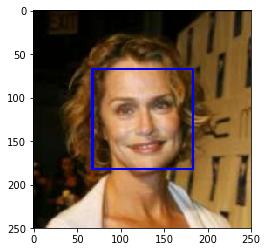

In [61]:
import cv2       
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [57]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path, cascade):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__  
In the supplied data there were:  
99% Human faces found  
11% Dog faces found  

In [247]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_faces = 0
dog_faces = 0
for human in human_files_short:
    if face_detector(human, face_cascade):
        human_faces += 1

for dog in dog_files_short:
    if face_detector(dog, face_cascade):
        dog_faces += 1

# 100 examples so each example is 1%
print('{}% Human faces found'.format(human_faces))
print('{}% Dog faces found'.format(dog_faces))

99% Human faces found
11% Dog faces found


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

It depends on the application, but by todays standards I would say that if the goal is to detect and draw bounding boxes of a face algorithms should support incomplete faces, further more if we want to detect the presence of a human then faces won't be sufficient for a lot of instances. 

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [63]:
## (Optional) TODO: Report the performance of another
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
face_cascade_alt2 = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt2.xml')
face_cascade_alt_tree = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt_tree.xml')

human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
alt_human_faces = 0
alt_dog_faces = 0
alt2_human_faces = 0
alt2_dog_faces = 0
alt_tree_human_faces = 0
alt_tree_dog_faces = 0
for human in human_files_short:
    if face_detector(human, face_cascade):
        alt_human_faces += 1
    if face_detector(human, face_cascade_alt2):
        alt2_human_faces += 1
    if face_detector(human, face_cascade_alt_tree):
        alt_tree_human_faces += 1

for dog in dog_files_short:
    if face_detector(dog, face_cascade):
        alt_dog_faces += 1
    if face_detector(dog, face_cascade_alt2):
        alt2_dog_faces += 1
    if face_detector(dog, face_cascade_alt_tree):
        alt_tree_dog_faces += 1

# 100 examples so each example is 1%
print('Alt {}% Human faces found'.format(alt_human_faces))
print('Alt {}% Dog faces found'.format(alt_dog_faces))
print('Alt2 {}% Human faces found'.format(alt2_human_faces))
print('Alt2 {}% Dog faces found'.format(alt2_dog_faces))
print('Alt Tree {}% Human faces found'.format(alt_tree_human_faces))
print('Alt Tree {}% Dog faces found'.format(alt_tree_dog_faces))

Alt 98% Human faces found
Alt 11% Dog faces found
Alt2 99% Human faces found
Alt2 20% Dog faces found
Alt Tree 50% Human faces found
Alt Tree 1% Dog faces found


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [74]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102760448/102853048 [============================>.] - ETA: 0s

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [75]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path, width=224, height=224):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(width, height))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths, width=224, height=224):
    list_of_tensors = [path_to_tensor(img_path, width, height) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [76]:
from keras.applications.resnet50 import decode_predictions
from keras.applications.resnet50 import preprocess_input as preprocess_resnet50_input

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_resnet50_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [77]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__  
In the supplied data there were:  
0% Human faces found  
100% Dog faces found  

In [209]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
human_faces = 0
dog_faces = 0
for human in human_files_short:
    if dog_detector(human):
        human_faces += 1

for dog in dog_files_short:
    if dog_detector(dog):
        dog_faces += 1
        
print('{}% Human faces found'.format(human_faces))
print('{}% Dog faces found'.format(dog_faces))

0% Human faces found
100% Dog faces found


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [15]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:05<00:00, 140.51it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__  
I started with something similar to DeepCNet from the Sparse Convolutional Neural Networks paper: https://arxiv.org/pdf/1409.6070.pdf, which gave good results on the CIFAR-10 image set. However the architecture was too big and long to train so I pulled most of it off doing tests with 2 epochs at a time and seeing if the model was moving at all. I finally found a combination of 16 CNN filters on the first layer, a leaky relu at 0.3 alpha, two max pools of size 2 and finally a flatten. The final output layer is a softmax to the 133 dog breed classes. I tried many combinations of turning these layers off or having a larger set of filters to begin. Almost all combinations yielded less than 1% on the first 2 epochs. The final architecture I chose leaps to 10% accuracy on the validation set almost immediately. For the optimiser I tried a slow SDG learning rate, and also adam but in the end chose rmsprop as it provided good quick results on low number of epochs. I enabled training data augmentation which also improved the test accuracy. I also increased the batch size to 100 and managed almost 10% after 10 epochs. I am surprised at this architecture getting such a high initial accuracy compared with my other attempts.

In [16]:
# helpers for training CNNs
import keras
import timeit

# graph the history of model.fit
def show_history_graph(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show() 

# callback to show the total time taken during training and for each epoch
class EpochTimer(keras.callbacks.Callback):
    train_start = 0
    train_end = 0
    epoch_start = 0
    epoch_end = 0
    
    def get_time(self):
        return timeit.default_timer()

    def on_train_begin(self, logs={}):
        self.train_start = self.get_time()
 
    def on_train_end(self, logs={}):
        self.train_end = self.get_time()
        print('Training took {} seconds'.format(self.train_end - self.train_start))
 
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_start = self.get_time()
 
    def on_epoch_end(self, epoch, logs={}):
        self.epoch_end = self.get_time()
        print('Epoch {} took {} seconds'.format(epoch, self.epoch_end - self.epoch_start))

In [79]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.pooling import GlobalAveragePooling2D

own_model = Sequential()
own_model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation=None, 
                        input_shape=(224, 224, 3)))
own_model.add(LeakyReLU(alpha=0.3))
own_model.add(MaxPooling2D(pool_size=2))
own_model.add(MaxPooling2D(pool_size=2))

own_model.add(Flatten())
own_model.add(Dense(133, activation='softmax'))
own_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_95 (Conv2D)           (None, 224, 224, 16)      208       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 224, 224, 16)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 133)               6673541   
Total params: 6,673,749
Trainable params: 6,673,749
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [30]:
opt = 'rmsprop'
own_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

Using real-time data augmentation.
Epoch 1/10
65/66 [============================>.] - ETA: 0s - loss: 4.1769 - acc: 0.0980Epoch 00000: val_loss improved from inf to 4.35909, saving model to saved_models/weights.best.model_own.hdf5
Epoch 0 took 52.82367539400002 seconds
66/66 [==============================] - 52s - loss: 4.1766 - acc: 0.0977 - val_loss: 4.3591 - val_acc: 0.0958
Epoch 2/10
65/66 [============================>.] - ETA: 0s - loss: 4.1407 - acc: 0.0972Epoch 00001: val_loss did not improve
Epoch 1 took 50.75422793100006 seconds
66/66 [==============================] - 50s - loss: 4.1411 - acc: 0.0965 - val_loss: 4.3932 - val_acc: 0.0874
Epoch 3/10
65/66 [============================>.] - ETA: 0s - loss: 4.0854 - acc: 0.1033Epoch 00002: val_loss improved from 4.35909 to 4.32164, saving model to saved_models/weights.best.model_own.hdf5
Epoch 2 took 51.42772559800005 seconds
66/66 [==============================] - 51s - loss: 4.0828 - acc: 0.1034 - val_loss: 4.3216 - val_acc

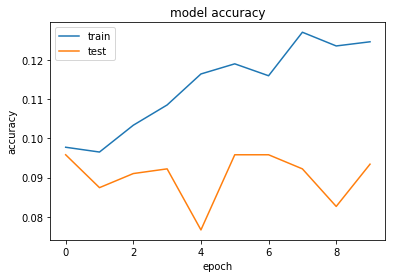

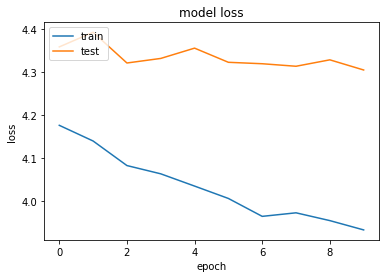

In [37]:
from keras.callbacks import ModelCheckpoint  
from keras.preprocessing.image import ImageDataGenerator

batch_size = 100
epochs = 10
data_augmentation = True # True

# train the model
model_own_file = 'saved_models/weights.best.model_own.hdf5'
checkpointer = ModelCheckpoint(filepath=model_own_file, verbose=1, save_best_only=True)
epochtimer = EpochTimer()

if not data_augmentation:
    print('Not using data augmentation.')
    hist = own_model.fit(train_tensors, train_targets, 
                         validation_data=(valid_tensors, valid_targets),
                         epochs=epochs, batch_size=batch_size, verbose=1,
                         callbacks=[checkpointer, epochtimer])
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(train_tensors)

    # Fit the model on the batches generated by datagen.flow().
    hist = own_model.fit_generator(datagen.flow(train_tensors, train_targets, batch_size=batch_size),
                                   steps_per_epoch=train_tensors.shape[0] // batch_size,
                                   epochs=epochs,
                                   callbacks=[checkpointer, epochtimer],
                                   validation_data=(valid_tensors, valid_targets), verbose=1)
show_history_graph(hist)

### Load the Model with the Best Validation Loss

In [38]:
own_model.load_weights(own_model_file)

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [39]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(own_model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)
# Test accuracy: 9.3301%

Test accuracy: 9.3301%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [40]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [41]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [42]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6500/6680 [============================>.] - ETA: 0s - loss: 12.0640 - acc: 0.1195Epoch 00000: val_loss improved from inf to 10.54470, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 0 took 1.6641768069998761 seconds
6680/6680 [==============================] - 1s - loss: 12.0275 - acc: 0.1216 - val_loss: 10.5447 - val_acc: 0.2024
Epoch 2/20
6620/6680 [============================>.] - ETA: 0s - loss: 9.5951 - acc: 0.2943Epoch 00001: val_loss improved from 10.54470 to 9.53692, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 1 took 1.4909216010000819 seconds
6680/6680 [==============================] - 1s - loss: 9.5944 - acc: 0.2943 - val_loss: 9.5369 - val_acc: 0.2946
Epoch 3/20
6600/6680 [============================>.] - ETA: 0s - loss: 8.9516 - acc: 0.3652Epoch 00002: val_loss improved from 9.53692 to 9.28700, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 2 took 1.4987728730002345 seconds
6

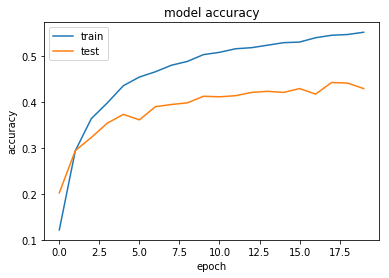

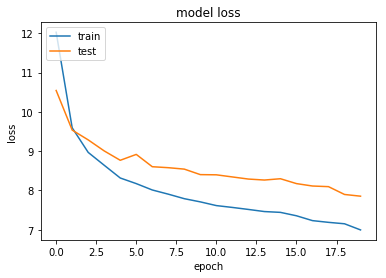

In [43]:
vgg16_model_file = 'saved_models/weights.best.VGG16.hdf5'
checkpointer = ModelCheckpoint(filepath=vgg16_model_file, 
                               verbose=1, save_best_only=True)
epochs = 20
batch_size = 20
epochtimer = EpochTimer()
hist = VGG16_model.fit(train_VGG16, train_targets, 
                       validation_data=(valid_VGG16, valid_targets),
                       epochs=epochs, batch_size=batch_size, callbacks=[checkpointer, epochtimer], verbose=1)
show_history_graph(hist)

### Load the Model with the Best Validation Loss

In [44]:
VGG16_model.load_weights(vgg16_model_file)

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [45]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)
# Test accuracy: 43.5407%

Test accuracy: 43.5407%


### Predict Dog Breed with the Model

In [46]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [47]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
network = 'InceptionV3'
bottleneck_features = np.load('bottleneck_features/Dog{}Data.npz'.format(network))
train_network = bottleneck_features['train']
valid_network = bottleneck_features['valid']
test_network = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  
I looked at the InceptionV3 architecture and did some reading and tried to create some similar layers to the last top layers of the original network under the idea that if they worked good for InceptionV3 they might work for this task.
The original Inception V3 Architecture top has an Average Pool, Dropout and a Fully Connected layer finally ending with a softmax. I chose to place an additional dropout in however it doesn't seem to make much difference. The choice of the LeakyReLU is from suggestions in the Spatially-sparse convolutional neural networks paper. I tried various combinations of network settings with 2 epochs and watched the initial gradient progress values. In the end I chose adam as the optimizer with a batch size of 64 and 30 epochs. It appears the bulk of the progress is made quickly and then the model seems to start to overfit as accuracy on the training set asymptotes but validation and testing progress stagnate, the history graph is at the end of the training output cell. In the end I was able to achieve 82% accuracy on the test set.

In [81]:
### TODO: Define your architecture.
inceptionV3_bneck_model = Sequential()
inceptionV3_bneck_model.add(GlobalAveragePooling2D(input_shape=train_network.shape[1:]))
inceptionV3_bneck_model.add(LeakyReLU(alpha=0.3))
inceptionV3_bneck_model.add(Dense(1024, activation='relu'))
inceptionV3_bneck_model.add(LeakyReLU(alpha=0.3))
inceptionV3_bneck_model.add(Dense(133, activation='softmax'))

inceptionV3_bneck_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 133)               136325    
Total params: 2,234,501
Trainable params: 2,234,501
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [82]:
### TODO: Compile the model.
opt = 'adam'
inceptionV3_bneck_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

Train on 6680 samples, validate on 835 samples
Epoch 1/30
6656/6680 [============================>.] - ETA: 0s - loss: 0.9493 - acc: 0.7599Epoch 00000: val_loss improved from inf to 0.76177, saving model to saved_models/weights.best.inceptionv3_bneck.hdf5
Epoch 0 took 1.7048230069995043 seconds
6680/6680 [==============================] - 1s - loss: 0.9469 - acc: 0.7603 - val_loss: 0.7618 - val_acc: 0.7701
Epoch 2/30
6592/6680 [============================>.] - ETA: 0s - loss: 0.3942 - acc: 0.8777Epoch 00001: val_loss improved from 0.76177 to 0.72474, saving model to saved_models/weights.best.inceptionv3_bneck.hdf5
Epoch 1 took 1.737776846000088 seconds
6680/6680 [==============================] - 1s - loss: 0.3924 - acc: 0.8783 - val_loss: 0.7247 - val_acc: 0.8060
Epoch 3/30
6464/6680 [============================>.] - ETA: 0s - loss: 0.2612 - acc: 0.9134Epoch 00002: val_loss improved from 0.72474 to 0.62651, saving model to saved_models/weights.best.inceptionv3_bneck.hdf5
Epoch 2 too

6680/6680 [==============================] - 1s - loss: 0.0093 - acc: 0.9973 - val_loss: 0.8889 - val_acc: 0.8539
Epoch 29/30
6592/6680 [============================>.] - ETA: 0s - loss: 0.0130 - acc: 0.9968Epoch 00028: val_loss did not improve
Epoch 28 took 1.615978723999433 seconds
6680/6680 [==============================] - 1s - loss: 0.0128 - acc: 0.9969 - val_loss: 0.8476 - val_acc: 0.8527
Epoch 30/30
6464/6680 [============================>.] - ETA: 0s - loss: 0.0103 - acc: 0.9977Epoch 00029: val_loss did not improve
Epoch 29 took 1.6169967660007387 seconds
6680/6680 [==============================] - 1s - loss: 0.0106 - acc: 0.9975 - val_loss: 0.8361 - val_acc: 0.8599
Training took 48.67391888199927 seconds


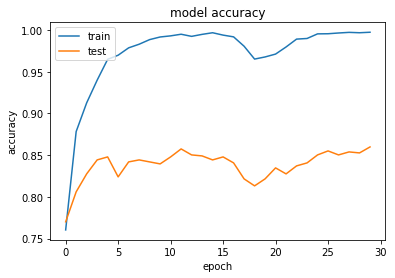

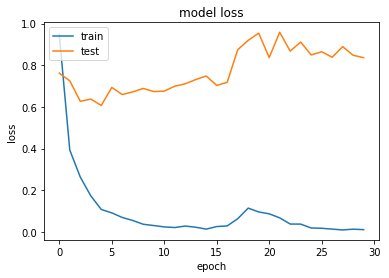

In [86]:
### TODO: Train the model.
epochs = 30
batch_size = 64
inceptionV3_bneck_model_file = 'saved_models/weights.best.{}.hdf5'.format('inceptionv3_bneck')
checkpointer = ModelCheckpoint(filepath=inceptionV3_bneck_model_file, 
                               verbose=1, save_best_only=True)
epochtimer = EpochTimer()

hist = inceptionV3_bneck_model.fit(train_network, train_targets,
                                   validation_data=(valid_network, valid_targets),
                                   epochs=epochs, batch_size=batch_size,
                                   callbacks=[checkpointer, epochtimer], verbose=1)
show_history_graph(hist)

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [87]:
### TODO: Load the model weights with the best validation loss.
inceptionV3_bneck_model.load_weights(inceptionV3_bneck_model_file)

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [88]:
### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
predictions = [np.argmax(inceptionV3_bneck_model.predict(np.expand_dims(feature, axis=0))) for feature in test_network]

# report test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)
# Test accuracy: 82.4163%

Test accuracy: 82.4163%


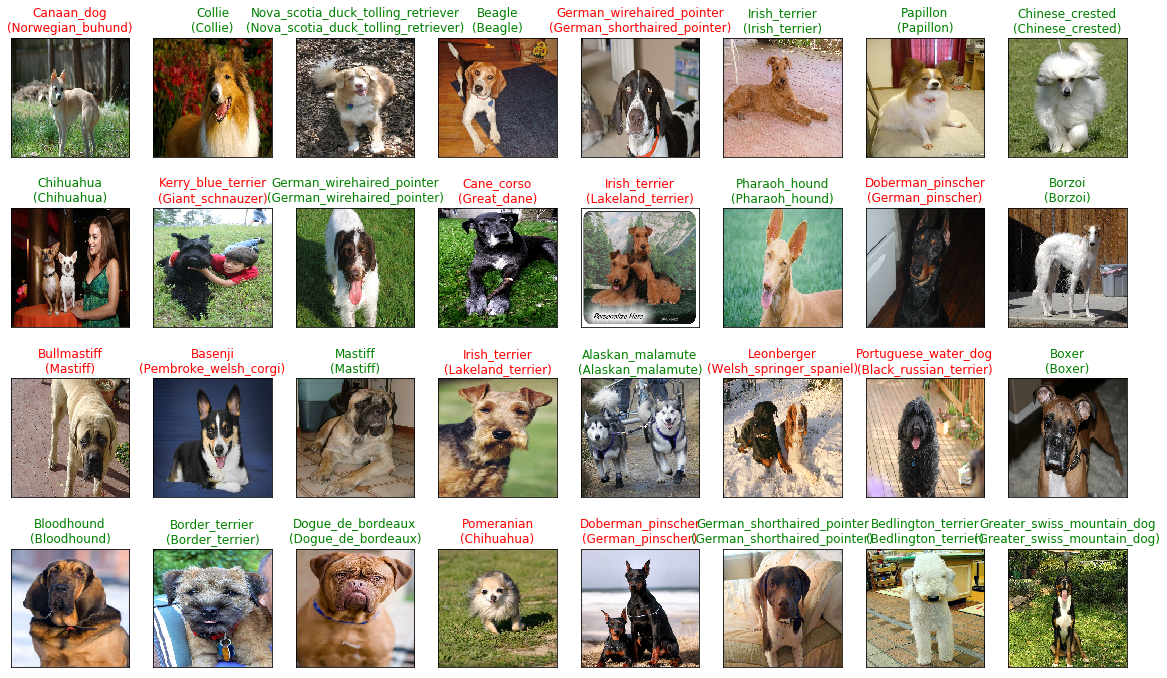

In [89]:
fig = plt.figure(figsize=(20, 12))
for i, idx in enumerate(np.random.choice(test_tensors.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(test_tensors[idx]))
    true_idx = np.argmax(test_targets[idx])
    pred_idx = predictions[idx]
    ax.set_title("{}\n({})".format(dog_names[pred_idx], dog_names[true_idx]),
                                  color=("green" if pred_idx == true_idx else "red"))

## Results
I managed to achieve a test accuracy of 82% on the Dog Breed data set by feeding the pregenerated Bottleneck features for the InceptionV3 model and feeding them through a GlobalAveragePooling2D layer, a LeakyReLU with alpha 0.3 and into a Dense 1024 node fully connected layer to bring down the dimensionality again. Finally I added another LeakyReLU alpha 0.3 and a Dense fully connected layer with softmax activation to predict across the 133 target classes. The hope with the last relu was to improve the results however it had no noticeable affect on the results.

I tried several variations of batch size and epochs, as well as tweaking some of the Model parameters.
Training per epoch was always quick, but results didn't change much after the first few Epochs.
Most attempts ranged between 78% - 82% on the test set.
My final version uses 30 epochs and a batch size of 64.

Below is the graph of how the network responded over each epoch.

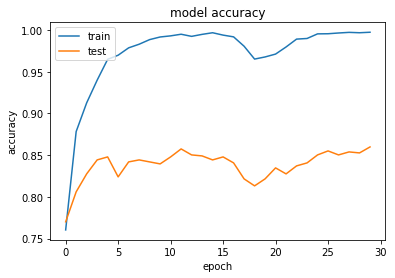

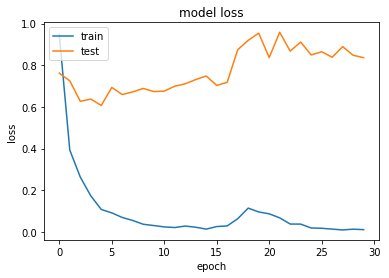

In [90]:
show_history_graph(hist)

## Version 2: Alternative Transfer and Finetune with InceptionV3
This is my second attempt at building a network that can beat the above 82% score. I took the idea from this GitHub code example on Transfer Learning and Finetuning: https://github.com/DeepLearningSandbox/DeepLearningSandbox/blob/master/transfer_learning/fine-tune.py

In [134]:
# InceptionV3 uses 299 x 299 images
from keras.applications.inception_v3 import preprocess_input
def paths_to_inception_tensor(img_paths, width=299, height=299):
    list_of_tensors = [preprocess_input(path_to_tensor(img_path, width, height)) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

inception_test_tensors = paths_to_inception_tensor(test_files)


100%|██████████| 836/836 [00:06<00:00, 126.81it/s]

In [68]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import ImageDataGenerator

img_width, img_height = 299, 299
batch_size = 100
num_classes = 133
train_dir = 'dogImages/train'
valid_dir = 'dogImages/valid'

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
)

validation_generator = validation_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
)

Found 6680 images belonging to 133 classes.
Found 835 images belonging to 133 classes.


In [80]:
from keras.models import Model
import math

base_model = InceptionV3(weights='imagenet', include_top=False)
for layer in base_model.layers:
    layer.trainable = False
output = base_model.output
output = GlobalAveragePooling2D()(output)
output = Dense(1024, activation='relu')(output)
final_layers = Dense(133, activation='softmax')(output)
finetune_model = Model(inputs=base_model.input, outputs=final_layers)
finetune_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Training Samples: 6680 Validation Samples: 835 Batch Size: 100 Steps: 67
Epoch 1/20
67/67 [==============================] - 177s - loss: 3.0342 - acc: 0.3683 - val_loss: 1.3919 - val_acc: 0.6311
Epoch 2/20
67/67 [==============================] - 156s - loss: 1.3405 - acc: 0.6323 - val_loss: 1.0052 - val_acc: 0.6814
Epoch 3/20
67/67 [==============================] - 158s - loss: 1.0270 - acc: 0.7079 - val_loss: 0.9833 - val_acc: 0.7317
Epoch 4/20
67/67 [==============================] - 153s - loss: 0.9211 - acc: 0.7247 - val_loss: 0.9603 - val_acc: 0.7305
Epoch 5/20
67/67 [==============================] - 156s - loss: 0.8067 - acc: 0.7627 - val_loss: 0.9420 - val_acc: 0.7281
Epoch 6/20
67/67 [==============================] - 154s - loss: 0.7568 - acc: 0.7684 - val_loss: 1.0441 - val_acc: 0.6970
Epoch 7/20
67/67 [==============================] - 157s - loss: 0.7038 - acc: 0.7820 - val_loss: 0.9688 - val_acc: 0.7078
Epoch 8/20
67/67 [==============================] - 156s - loss: 0

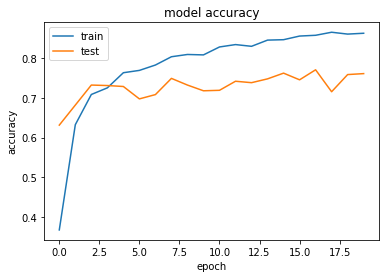

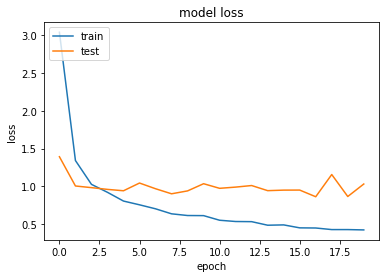

In [137]:
steps = math.ceil(train_tensors.shape[0]/batch_size)
validation_steps = math.ceil(valid_tensors.shape[0]/batch_size)
print('Training Samples: {} Validation Samples: {} Batch Size: {} Steps: {}'.format(
      train_tensors.shape[0], valid_tensors.shape[0], batch_size, steps))

epochs = 20
epochtimer = EpochTimer()

hist = finetune_model.fit_generator(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    steps_per_epoch=steps,
    validation_steps=validation_steps,
    callbacks=[epochtimer]
)
show_history_graph(hist)

top_model_file = 'saved_models/weights.best.{}.hdf5'.format('inceptionv3_top')
finetune_model.save(top_model_file)

In [138]:
predictions = [np.argmax(finetune_model.predict(np.expand_dims(feature, axis=0))) for feature in inception_test_tensors]
# report test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 82.7751%


In [ ]:
from keras.optimizers import SGD

# NB_IV3_LAYERS corresponds to the top 2 inception blocks in the inceptionv3 architecture
NB_IV3_LAYERS_TO_FREEZE = 172
for layer in finetune_model.layers[:NB_IV3_LAYERS_TO_FREEZE]:
    layer.trainable = False
for layer in finetune_model.layers[NB_IV3_LAYERS_TO_FREEZE:]:
    layer.trainable = True
# Use a slow stable learning method to prevent introducing bad noise into the lower layers
finetune_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

Training Samples: 6680 Validation Samples: 835 Batch Size: 100 Steps: 67
Epoch 1/20
67/67 [==============================] - 187s - loss: 0.3615 - acc: 0.8793 - val_loss: 0.8258 - val_acc: 0.7749
Epoch 2/20
67/67 [==============================] - 170s - loss: 0.2846 - acc: 0.9060 - val_loss: 0.7545 - val_acc: 0.8024
Epoch 3/20
67/67 [==============================] - 168s - loss: 0.2512 - acc: 0.9200 - val_loss: 0.7609 - val_acc: 0.7916
Epoch 4/20
67/67 [==============================] - 169s - loss: 0.2240 - acc: 0.9292 - val_loss: 0.7371 - val_acc: 0.7988
Epoch 5/20
67/67 [==============================] - 169s - loss: 0.2160 - acc: 0.9282 - val_loss: 0.6772 - val_acc: 0.8000
Epoch 6/20
67/67 [==============================] - 167s - loss: 0.1957 - acc: 0.9358 - val_loss: 0.6673 - val_acc: 0.8275
Epoch 7/20
67/67 [==============================] - 168s - loss: 0.1979 - acc: 0.9374 - val_loss: 0.6473 - val_acc: 0.8180
Epoch 8/20
67/67 [==============================] - 167s - loss: 0

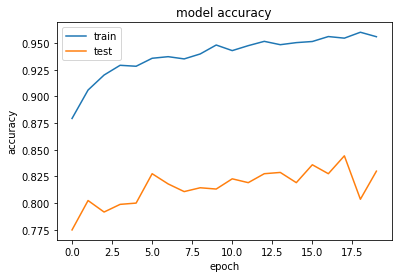

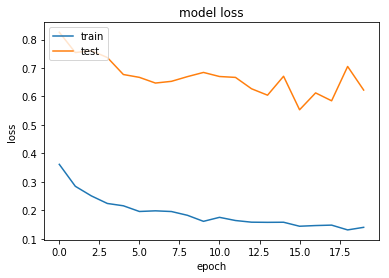

In [140]:
steps = math.ceil(train_tensors.shape[0]/batch_size)
validation_steps = math.ceil(valid_tensors.shape[0]/batch_size)
print('Training Samples: {} Validation Samples: {} Batch Size: {} Steps: {}'.format(
      train_tensors.shape[0], valid_tensors.shape[0], batch_size, steps))

epochs = 20
epochtimer = EpochTimer()

hist = finetune_model.fit_generator(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    steps_per_epoch=steps,
    validation_steps=validation_steps,
    callbacks=[epochtimer]
)
show_history_graph(hist)

finetune_model_file = 'saved_models/weights.best.{}.hdf5'.format('inceptionv3_finetune')
finetune_model.save(finetune_model_file)

In [141]:
predictions = [np.argmax(finetune_model.predict(np.expand_dims(feature, axis=0))) for feature in inception_test_tensors]
# report test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

# 2 epochs per stage
# Test accuracy: 81.4593%

# 3 epochs per stage
# Test accuracy: 84.9282%

# 10 epochs per stage
# Test accuracy: 86.2440%

# 20 epochs
# Test accuracy: 87.2010%

Test accuracy: 87.2010%


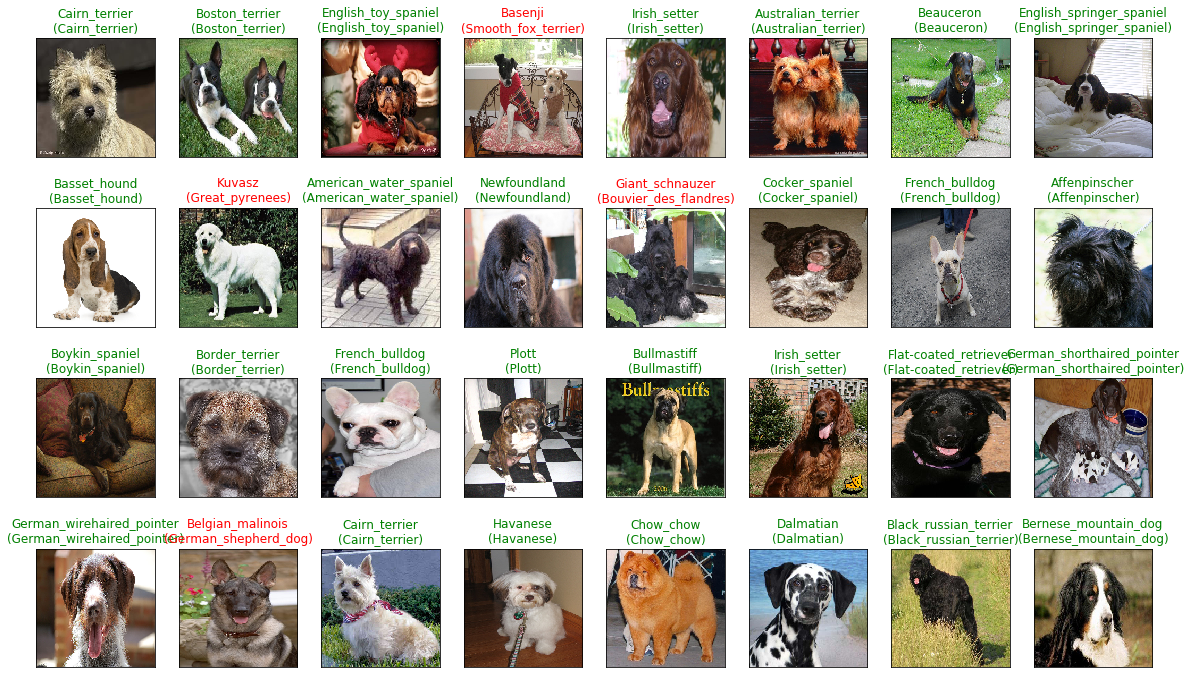

In [145]:
fig = plt.figure(figsize=(20, 12))
for i, idx in enumerate(np.random.choice(test_tensors.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(test_tensors[idx]))
    true_idx = np.argmax(test_targets[idx])
    pred_idx = predictions[idx]
    ax.set_title("{}\n({})".format(dog_names[pred_idx], dog_names[true_idx]),
                                  color=("green" if pred_idx == true_idx else "red"))

## Results
Using "Grad student descent" and some suggestions from blog posts, papers and GitHub example code, I managed to achieve a test accuracy of 87% on the Dog Breed data set by first training a new top layer for 20 epochs with augmented training and validation data using up to 30 degree rotation and 0.2 for width and height shifting, and 0.2 for shear and zoom range.

The new output top layers are a GlobalAveragePooling2D layer and a fully connected Dense 1024 node layer with a relu activation, to bring the dimensionality down. The final output layer is a softmax of 133 matching the number of dog breed classes.

I chose rmsprop as the optimizer and wanted the weights for this new model top to train from scratch fast. The bottom of the network was frozen and the new top was trained for 20 epochs and a batch size of 100 with augmented test and validation data generation.

After the initial transfer step the network scored around 82% which is similar to my previous network where I simply trained a new top with outputs.

For the fine tuning step I froze the layers after 172 (as noted in the GitHub example code) and trained the initial part of the network the same way for 20 epochs and with a more cautious optimizer using SGD, a learning rate of 0.0001 and momentum set to 0.9.

I tried several variations of batch size and epochs, as well as tweaking some of the Model parameters.
I trained this a few different times to see what the results were like.
At 2 epochs the results were 81%. This increased to 85% at 3 epochs and 86% at 10 epochs.

Finally I acheived 87.2% on the test set with 20 epochs of transfer and fine tuning.

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [119]:
finetune_model_file = 'saved_models/weights.best.{}.hdf5'.format('inceptionv3_finetune')
finetune_model.load_weights(finetune_model_file)

In [124]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as preprocess_inception_input

def extract_InceptionV3(tensor):
    return InceptionV3(weights='imagenet', include_top=False).predict(preprocess_inception_input(tensor))

### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
def breed_detector(img_path, selected_model, bottleneck=True, img_width=223, img_height=223):

    tensor = path_to_tensor(img_path, img_width, img_height)
    if bottleneck:
        tensor = extract_InceptionV3(tensor)
    else:
        tensor = preprocess_inception_input(tensor)

    predictions = selected_model.predict(tensor)
    y_hat = np.argmax(predictions)
    return dog_names[y_hat]

In [71]:
import matplotlib.image as mpimg

def show_image(img_path):
    img = mpimg.imread(img_path)
    fig = plt.figure()
    plt.subplot()
    plt.imshow(img)
    plt.axis('off')
    plt.plot()

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [114]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def dog_or_not(img_path):
    print('Using image: {}'.format(img_path))
    face_found = face_detector(img_path, face_cascade_alt2)
    dog_found = dog_detector(img_path)
    print('face_found {}'.format(face_found))
    print('dog_found {}'.format(dog_found))
    if face_found:
        print('Human Face Found')
    if dog_found:
        print('Dog Found')
    pred = breed_detector(img_path, finetune_model, False, 229, 229)
    print('Dog Breed {}'.format(pred))

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__  
The algorithm using my InceptionV3 transfer and fine tuned model performs better than I expected. It generally detects dog breeds correctly in my tests below. Its funny what breeds it picks for Chewbacca and Winston Churchill as he is often referred to as the British Bulldog but I think I can see the resemblance with the Dogue de bordeaux.

The cat image I tested it on seems to pass but there are some issues, Winston is neither dog nor human, which might not be far from the truth, and the Beagle seems to be both. To improve it I would add some additional Haar features to look for smiles and eyes as well as train a CNN for detecting humans the same was I did for dog breeds.

In [115]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

In [116]:
def check_image(img_path):
    show_image(img_path)
    dog_or_not(img_path)

Using image: images/more/border_collie.jpg
face_found False
dog_found True
Dog Found
Dog Breed Border_collie


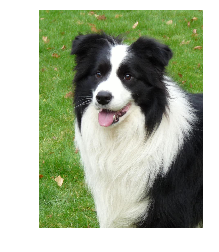

In [250]:
check_image('images/more/border_collie.jpg')

Using image: images/more/dachshund.jpg
face_found False
dog_found True
Dog Found
Dog Breed Dachshund


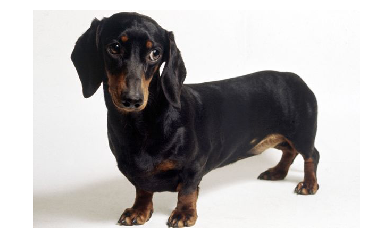

In [251]:
check_image('images/more/dachshund.jpg')

Using image: images/more/chihuahua.jpg
face_found True
dog_found False
Human Face Found
Dog Breed Chihuahua


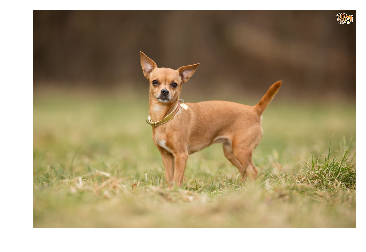

In [252]:
check_image('images/more/chihuahua.jpg')

Using image: images/more/beagle.jpg
face_found True
dog_found True
Human Face Found
Dog Found
Dog Breed Beagle


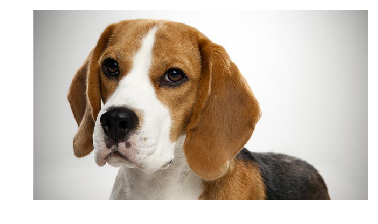

In [253]:
check_image('images/more/beagle.jpg')

Using image: images/more/chewbacca.jpg
face_found False
dog_found True
Dog Found
Dog Breed Yorkshire_terrier


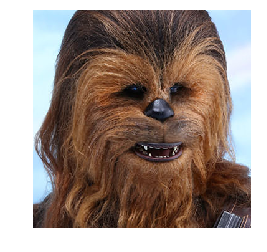

In [255]:
check_image('images/more/chewbacca.jpg')

Using image: images/more/cat.jpg
face_found False
dog_found False
Dog Breed French_bulldog


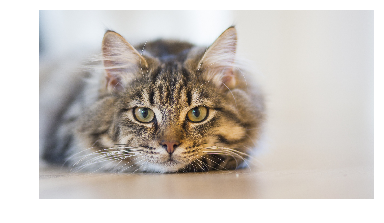

In [256]:
check_image('images/more/cat.jpg')

Using image: images/more/bulldog.jpg
face_found False
dog_found True
Dog Found
Dog Breed Bulldog


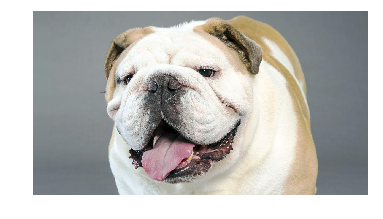

In [257]:
check_image('images/more/bulldog.jpg')

Using image: images/more/winston.jpg
face_found False
dog_found False
Dog Breed Dogue_de_bordeaux


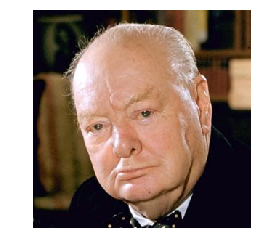

In [258]:
check_image('images/more/winston.jpg')

Using image: images/more/0.jpg
face_found True
dog_found False
Human Face Found
Dog Breed Silky_terrier


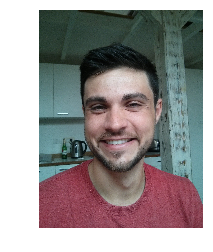

In [259]:
check_image('images/more/0.jpg')

Using image: images/more/1.jpg
face_found True
dog_found False
Human Face Found
Dog Breed Cane_corso


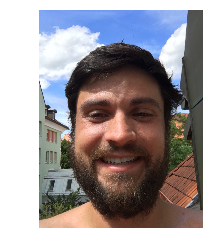

In [260]:
check_image('images/more/1.jpg')

Using image: images/more/2.jpg
face_found True
dog_found False
Human Face Found
Dog Breed Yorkshire_terrier


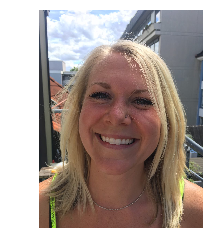

In [261]:
check_image('images/more/2.jpg')

Using image: images/more/3.jpg
face_found True
dog_found False
Human Face Found
Dog Breed Dogue_de_bordeaux


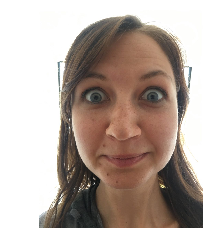

In [262]:
check_image('images/more/3.jpg')

Using image: images/more/4.jpg
face_found True
dog_found False
Human Face Found
Dog Breed Irish_water_spaniel


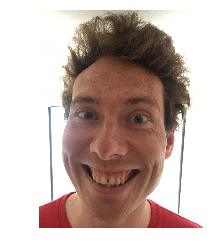

In [263]:
check_image('images/more/4.jpg')

## Step 8: Cool Extra Stuff

<img src="./images/clades.jpg" alt="Dog Breed Genetic Clades" style="width: 50%; float: right;" />
## Dog Breed Genetic Clades

I read a recent paper that was published in Cell titled:

[*Genomic Analyses Reveal the Influence of Geographic Origin, Migration, and Hybridization on Modern Dog Breed Development*](http://www.cell.com/cell-reports/fulltext/S2211-12471730456-4)

The authors did the largest genetic test of dog breeds ever published and grouped 161 breeds into 23 supported genetic clades.

I realised this would be great data to mix into the dog breed classifier.

So I grabbed the original data from their [spreadsheet](http://www.cell.com/cms/attachment/2095610627/2077666845/mmc2.xlsx).

After mixing it with the Udacity Dog Classifier data and doing some reading of wikipedia to double check some alternative breed names or spellings, I was left with 25 breeds in the Udacity list which were not represented in the genomic analysis data.

This included breeds such as Basenji, Bluetick coonhound, German pinscher and the Entlebucher mountain dog.

For each of these breeds I read about them on wikipedia and looked at their related breeds and assigned a clade, for many this was fairly obvious.

Wikipedia says the Bluetick coonhound is a Scent Hound and as you can see it also has those tell tale Scent Hound ears like the Dachshund, Bloodhound, Beagle and Basset hound. Bluetick coon hound left and Dachshund right.
<div style="clear:both"></div>
<img src="./images/Dachshund.jpg" alt="Dachshund" style="height: 300px; float: right;" />
<img src="./images/Bluetick_coon_hound.jpg" alt="Bluetick coon hound" style="height: 300px; float: left;" />
<div style="clear:both"></div>

The Entlebucher mountain dog is from Switzerland and is related to the Greater swiss mountain dog, they even look the same, so I think its safe to assign it the clade Alpine. Entlebucher mountain dog left and Greater swiss mountain dog right.

<div style="clear:both"></div>
<img src="./images/Greater_swiss_mountain_dog.jpg" alt="Greater swiss mountain dog" style="height: 300px; float: right;" />
<img src="./images/Entlebucher_mountain_dog.jpg" alt="Entlebucher mountain dog" style="height: 300px; float: left;" />
<div style="clear:both"></div>



However there were two dogs which I couldn't find anything of relation in the study, Basenji and the Canaan dog. I read about them and they appear to belong to a class of outcast dogs or [Pariah dogs](https://en.wikipedia.org/wiki/Pariah_dog).

These are dogs which have existed from ancient times when dogs were first domesticated from wild animals to creatures of utility for humans. Interestingly they look similar. Canaan Dog left and Basenji right.

<div style="clear:both"></div>
<img src="./images/Basenji.jpg" alt="Basenji" style="height: 300px; float: right;" />
<img src="./images/Canaan_dog.jpg" alt="Canaan dog" style="height: 300px; float: left;" />
<div style="clear:both"></div>

In my mind these dogs could be more related than they are to modern dogs. The look of these dogs remineded me of another wild dog from my home country Australia, the infamous Dingo.

<div style="clear:both"></div>
<img src="./images/Dingo.jpg" alt="Dingo" style="height: 300px; float: left;" />
<div style="clear:both"></div>

I don't think its a coincidence that my classifier thinks the Dingo is a Canaan dog.

So I assigned these dogs a "new" clade called Pariah dog.

The data is in a csv file called dog_breed_to_clade.csv with an extra column Interpolated where 0 means original data, 1 means I guessed the clade based on evidence found online and my human intuition and 2 for the Pariah dog which I made up myself.

In [100]:
import pandas as pd
dog_clade_filename = 'dog_breed_to_clade.csv'
df1 = pd.read_csv(dog_clade_filename)

print(df1[['Name', 'Clade']])

                                   Name               Clade
0                         Affenpinscher           Schnauzer
1                          Afghan_hound       Mediterranean
2                      Airedale_terrier             Terrier
3                                 Akita         Asian Spitz
4                      Alaskan_malamute         Asian Spitz
5                   American_eskimo_dog        Nordic Spitz
6                     American_foxhound         Scent Hound
7        American_staffordshire_terrier    European Mastiff
8                American_water_spaniel             Spaniel
9                Anatolian_shepherd_dog       Mediterranean
10                Australian_cattle_dog            UK Rural
11                  Australian_shepherd            UK Rural
12                   Australian_terrier             Terrier
13                              Basenji          Pariah dog
14                         Basset_hound         Scent Hound
15                               Beagle 

Cool now lets write some functions so we can get clade output in our dog classifier function.

In [101]:
def breed_clade(breed_index):
    df = df1.set_index('Index')
    row = df.loc[breed_index]
    return row['Clade']

In [102]:
# first dog is index: 0 name: Affenpinscher clade: Schnauzer
print(breed_clade(0))
print(dog_names[0])

Schnauzer
Affenpinscher


In [126]:
def related_breeds(breed_index):
    original = dog_names[breed_index]
    clade = breed_clade(breed_index)
    df = df1.set_index('Clade')
    breeds = df.loc[clade]['Name']
    other_breeds = []
    for breed in breeds:
        if breed != original:
            other_breeds.append(breed)
    return other_breeds

In [128]:
# index: 24 name: Black and tan coonhound clade: Scent Hound
related = related_breeds(24)
print(related)

['American_foxhound', 'Basset_hound', 'Beagle', 'Bloodhound', 'Bluetick_coonhound', 'Dachshund', 'Otterhound', 'Petit_basset_griffon_vendeen', 'Plott']


In [161]:
def name_to_index(dog_name):
    df = df1.set_index('Name')
    row = df.loc[dog_name]
    return row['Index']

def dog_or_not_clade(img_path):
    print('Using image: {}'.format(img_path))
    face_found = face_detector(img_path, face_cascade_alt2)
    dog_found = dog_detector(img_path)
    print('face_found {}'.format(face_found))
    print('dog_found {}'.format(dog_found))
    if face_found:
        print('Human Face Found')
    if dog_found:
        print('Dog Found')
    pred = breed_detector(img_path, finetune_model, False, 229, 229)
    print('Dog Breed {}'.format(pred))
    dog_index = name_to_index(pred)
    print('Dog Clade: {}'.format(breed_clade(dog_index)))
    rel_breeds = related_breeds(dog_index)
    print('Related Dogs by Clade: {}'.format(rel_breeds))
    rel_images = get_dog_images(rel_breeds)
    print('Images of Related Dogs:')
    for (rel_breed, rel_image) in rel_images:
        print(rel_breed)
        show_image(rel_image)
    
def check_image_clade(img_path):
    show_image(img_path)
    dog_or_not_clade(img_path)

In [154]:
import os, random
def get_dog_images(breeds, num=3):
    image_array = []
    count = 0
    for breed in breeds:
        if count < num:
            count += 1
            idx = str(int(name_to_index(breed)) + 1).zfill(3)
            path = './dogImages/train/{}.{}'.format(idx, breed)
            file = random.choice(os.listdir(path))
            image_array.append((breed, os.path.join(path, file)))
    return image_array

In [156]:
print(get_dog_images(['Border_collie', 'Border_collie', 'Border_collie', 'Border_collie']))

[('Border_collie', './dogImages/train/029.Border_collie/Border_collie_02047.jpg'), ('Border_collie', './dogImages/train/029.Border_collie/Border_collie_01996.jpg'), ('Border_collie', './dogImages/train/029.Border_collie/Border_collie_02041.jpg')]


Using image: images/more/border_collie.jpg
face_found False
dog_found True
Dog Found
Dog Breed Border_collie
Dog Clade: UK Rural
Related Dogs by Clade: ['Australian_cattle_dog', 'Australian_shepherd', 'Bearded_collie', 'Borzoi', 'Cardigan_welsh_corgi', 'Collie', 'Greyhound', 'Irish_wolfhound', 'Italian_greyhound', 'Old_english_sheepdog', 'Pembroke_welsh_corgi']
Images of Related Dogs:
Australian_cattle_dog
Australian_shepherd
Bearded_collie


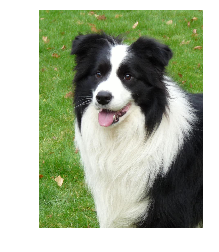

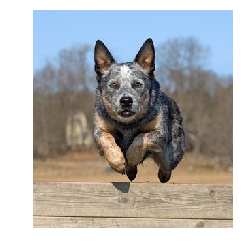

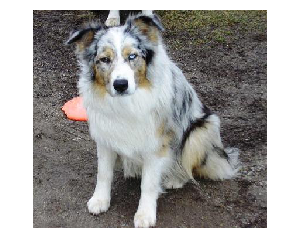

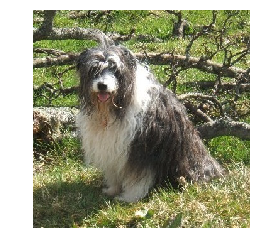

In [162]:
# Test the faithful old Border Collie first :)
check_image_clade('images/more/border_collie.jpg')

In [ ]:

# wrong but close and we know they are related by clade
check_image_clade('images/Bluetick_coon_hound.jpg')

Using image: images/Entlebucher_mountain_dog.jpg
face_found False
dog_found True
Dog Found
Dog Breed Greater_swiss_mountain_dog
Dog Clade: Alpine
Related Dogs by Clade: ['Bernese_mountain_dog', 'Entlebucher_mountain_dog', 'Saint_bernard']
Images of Related Dogs:
Bernese_mountain_dog
Entlebucher_mountain_dog
Saint_bernard


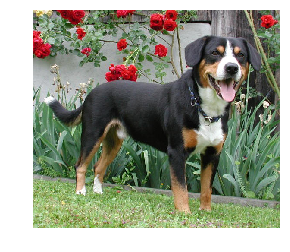

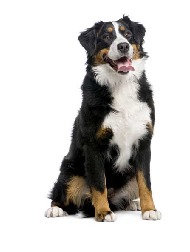

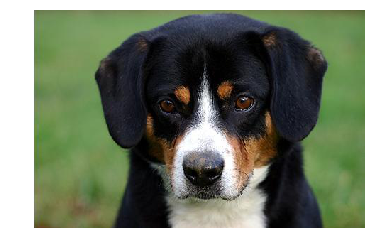

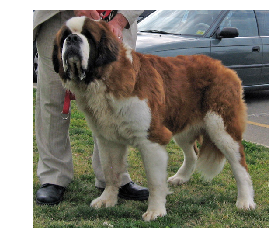

In [163]:
# wrong but close and we know they are related by clade
check_image_clade('images/Entlebucher_mountain_dog.jpg')

Using image: images/Dingo.jpg
face_found False
dog_found False
Dog Breed Canaan_dog
Dog Clade: Pariah dog
Related Dogs by Clade: ['Basenji']
Images of Related Dogs:
Basenji


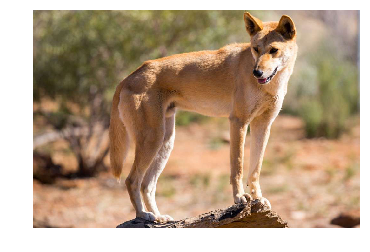

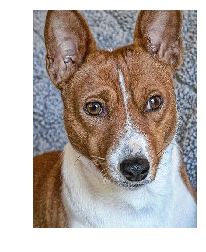

In [164]:
# Dingo looks like other Pariah dogs
check_image_clade('images/Dingo.jpg')

## Thoughts
This was really cool and fun and I am considering adding this data to the Mobile App "What Dog?" I also made which I will discuss below. I think another good use of this data would be to aid in determining which dog is detected. In the case above where the Entlebucher mountain dog was incorrectly classified as the Greater swiss mountain dog, I think both the model and the final inference process can be augmented to better improve the results and provide users with additional interesting information.